# Testing

This notebook is to test that a transmon behaves as expected when it is driven.

In [1]:
# imports
import numpy as np
from qutip import basis
import matplotlib.pyplot as plt
from transmon_code.transmon import *
from transmon_code.simulate import *
from transmon_code.helpers import *
from transmon_code.shapes import H1_coeffs

In [2]:
# define the transmon

tr = Transmon(n_levels=8, initial_state=0, Ω=2*np.pi*3981, α=2*np.pi*-199)

# for a pulse of length 0.024
tr.X90_args = {'A': 1.02431707152378, 'τ': 0.024, 'λ': -1.4702485711260789, 'α': tr.α, 'ω': tr.Ω, 'final_Z_rot': 0.2555209480765517}

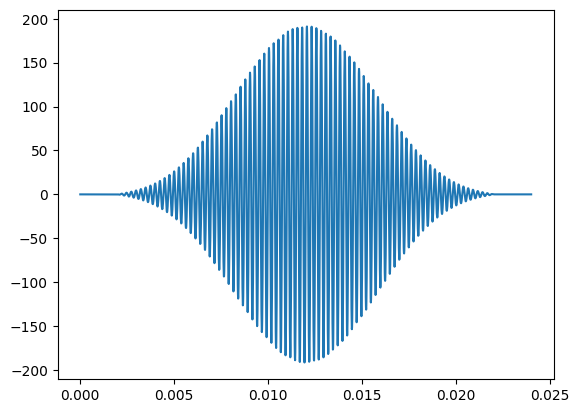

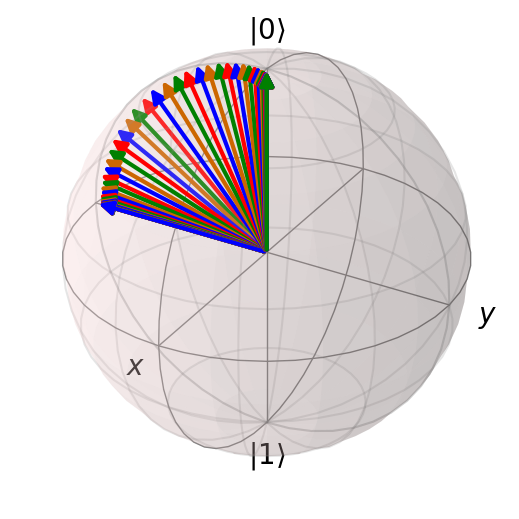

Fidelity (f):                0.9991584241687265
Measured error (1-f):        0.0008415758312735333

Leakage error:               0.0008415745258863688
Theoretical coherence error: 0.0
Error accounted for:         0.0008415745258863688

Error unaccounted for:       1.305387164465474e-09


In [3]:
# test an X90 pulse from 0 to - (minus)

targ = (basis(tr.n_levels, 0)-1j*basis(tr.n_levels, 1)).unit()

res, f = simulate(tr, tr.X90_args, target=targ, noise=False, plot=True)

break_down_errors(tr, tr.X90_args["τ"], res[-1], f)

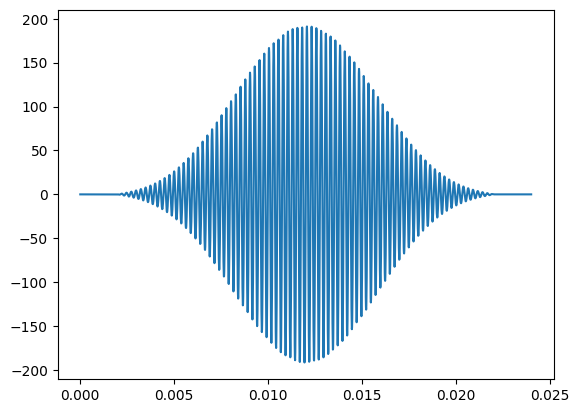

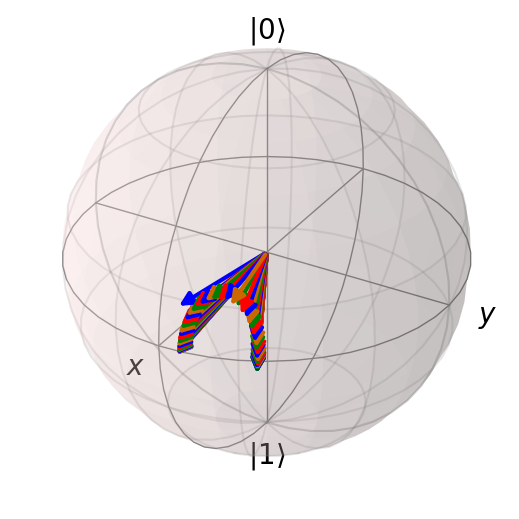

Fidelity (f):                0.9795717135387378
Measured error (1-f):        0.020428286461262157

Leakage error:               0.004341361951890775
Theoretical coherence error: 0.0
Error accounted for:         0.004341361951890775

Error unaccounted for:       0.01608692450937138


In [4]:
# test an X90 pulse on a random initial state

tr.ψ0 = expand(rand_ket(2), tr.n_levels).unit()
targ = expand(calculate_target_state([U(gate_angles["X90"])], truncate(tr.ψ0), plot=False), tr.n_levels).unit()

res, f = simulate(tr, tr.X90_args, target=targ, noise=False, plot=True)

break_down_errors(tr, tr.X90_args["τ"], res[-1], f)

tr.ψ0 = basis(tr.n_levels, 0)

Fidelity (f):                0.9269475275675395
Measured error (1-f):        0.07305247243246049

Leakage error:               0.010847292959193065
Theoretical coherence error: 0.0
Error accounted for:         0.010847292959193065

Error unaccounted for:       0.062205179473267425


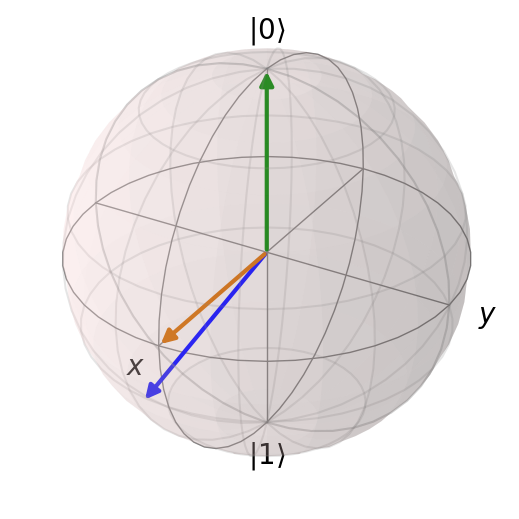

In [5]:
# test a noisy circuit by simulating each pulse individually

# define which two gates are to be tested
gate1 = "X90"
gate2 = "Z90"

# setup transmon and target
target = calculate_target_state([gate1, gate2], tr.ψ0)
target = expand(target, tr.n_levels)
tr.ψ0 = basis(tr.n_levels, 0)

# prep for plotting
b = Bloch()
b.make_sphere()
b.add_states(truncate(tr.ψ0))
b.add_states(truncate(target))

# gate 1
θ, φ, λ = gate_angles[gate1]
total_phase = 0

total_phase += (λ-np.pi/2)
args = tr.get_noisy_args()
args["φ"] += total_phase
tr.ψ0 = simulate(tr, args, target=None, plot=False)[-1]

total_phase += (np.pi-θ)
args = tr.get_noisy_args()
args["φ"] += total_phase
tr.ψ0 = simulate(tr, args, target=None, plot=False)[-1]

total_phase += (φ-np.pi/2)

# gate 2
θ, φ, λ = gate_angles[gate2]
total_phase += (λ-np.pi/2)
args = tr.get_noisy_args()
args["φ"] += total_phase
tr.ψ0 = simulate(tr, args, target=None, plot=False)[-1]

total_phase += (np.pi-θ)
args = tr.get_noisy_args()
args["φ"] += total_phase
results = simulate(tr, args, target=None, plot=False)

# final rotation to account for virtual z gates throughout
total_phase += (φ-np.pi/2)
result = rotate_z(results[-1], total_phase)

# final output

break_down_errors(tr, tr.X90_args["τ"], result, fidelity(result, target)**2)

b.add_states(truncate(result))
b.render()
b.show()

Fidelity (f):                0.849633097200327
Measured error (1-f):        0.15036690279967302

Leakage error:               0.009600187107908241
Theoretical coherence error: 0.0
Error accounted for:         0.009600187107908241

Error unaccounted for:       0.14076671569176477


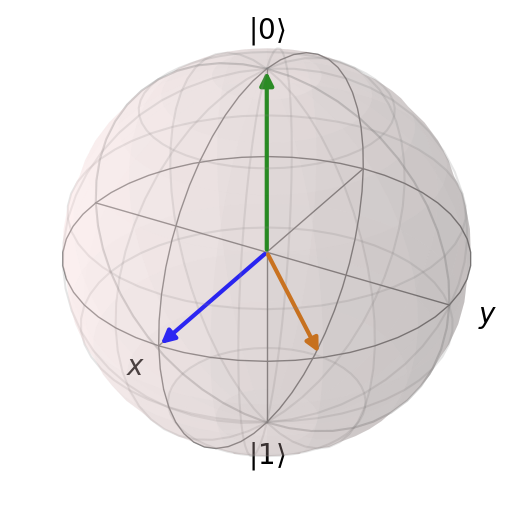

In [8]:
# test a circuit using simulate_circuit

# setup transmon and gates
tr.ψ0 = basis(tr.n_levels, 0)
gate1 = "X90"
gate2 = "Z90"
gate3 = "Z180"
gate4 = "Y90"

# define the circuit
c = [U(gate_angles[gate1]), U(gate_angles[gate2]), U(gate_angles[gate3]), U(gate_angles[gate4])]
c = [U(gate_angles[gate1]), U(gate_angles[gate2])]

# find target
targ = calculate_target_state(c, tr.ψ0)

# simulate
res, f = simulate_circuit2(tr, c, plot=True)